# Laboratorio de predicción lineal

## Intentaremos aplicar predicción lineal sobre señales de voz.

In [1]:
%pip install wget

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import wget
import scipy.io.wavfile as wave
import IPython
from scipy.linalg import toeplitz, inv
from scipy.fftpack import fft

## Sabiendo que las señales de voz pueden ser modeladas con un modelo autorregresivo:

### 1. Realizar una grabación de duración T = 2 s y fs = 8 kHz de los sonidos /a/ y /sh/.

In [3]:
a_url = 'https://raw.githubusercontent.com/ManuMollon261297/PASA/master/TP3/recordings/a.wav'
a_file = wget.download(a_url)

sh_url = 'https://raw.githubusercontent.com/ManuMollon261297/PASA/master/TP3/recordings/sh.wav'
sh_file = wget.download(sh_url)

In [4]:
fs, a_arr = wave.read(a_file)
# Downsample fs to 8KHz
desired_fs = 8000
final_len = int(len(a_arr) * (8000/fs))
resampled_a = sig.resample(a_arr, final_len)
norm_a = resampled_a/np.amax(abs(resampled_a))

print("fs = "+str(desired_fs))
print("Number of samples = "+ str(len(resampled_a)))
IPython.display.Audio(resampled_a,rate=desired_fs)

fs = 8000
Number of samples = 20640


In [5]:
fs, sh_arr = wave.read(str(sh_file))

# Downsample fs to 8KHz
desired_fs = 8000
final_len = int(len(sh_arr) * (8000/fs))
resampled_sh = sig.resample(sh_arr, final_len)
norm_sh = resampled_sh/np.amax(abs(resampled_sh))

print("fs = "+str(desired_fs))
print("Number of samples = "+ str(len(resampled_sh)))
IPython.display.Audio(resampled_sh,rate=desired_fs)

fs = 8000
Number of samples = 19616


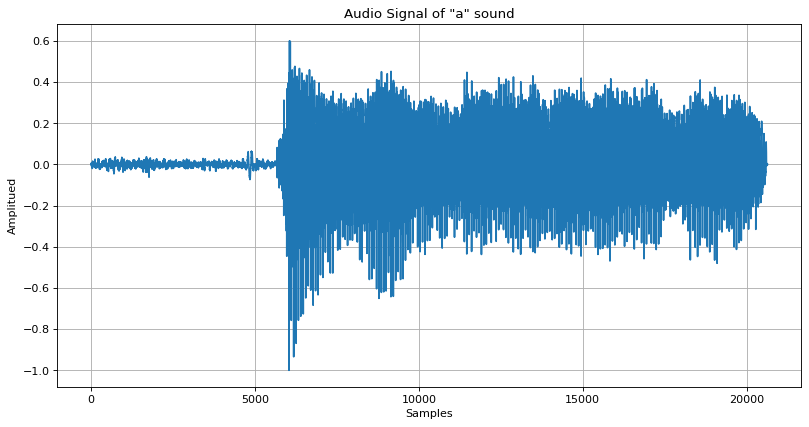

In [6]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitued')
plt.xlabel('Samples')
plt.title('Audio Signal of "a" sound')
plt.grid('on')
plt.plot(norm_a)
plt.show()

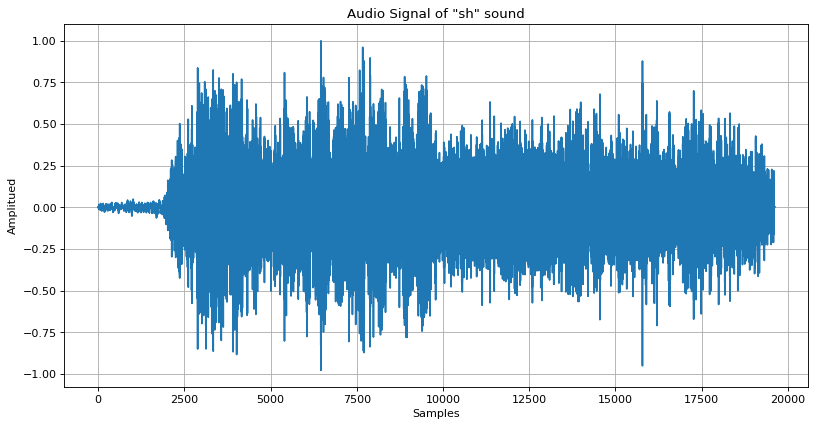

In [7]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitued')
plt.xlabel('Samples')
plt.title('Audio Signal of "sh" sound')
plt.grid('on')
plt.plot(norm_sh)
plt.show()

### 2. Para ambos sonidos, realizar la predicción forward con $ N_{o} = 1 $, y representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.

In [8]:
def autocorreltion(x):
  norm_x = (x - x.mean())/(abs(x - x.mean()).max())
  return np.correlate(norm_x,norm_x,mode='full') / len(x)

def LevinsonDurbin(r,debug = False):
  last_delta = np.conj(r[1])
  a_coefs = 1
  M = len(r)-1
  P_values = []
  P_values.append(r[0])
  for i in range(1,M+1):
    k = (-last_delta) / P_values[-1]
    last_coefs = a_coefs
    a_coefs = np.ones(i+1, dtype= np.float64)
    a_coefs[-1] = k 
    if (i>1):
      a_coefs[1:-1] = last_coefs[1:] + k*np.flip(np.conj(last_coefs[1:]))
    P_values.append( P_values[-1] * (1- (abs(k)**2) ) )
    if (i < M):
      last_delta = np.dot(np.flip(r[1:i+2]),a_coefs)
    if debug:
      print("m = "+str(i))
      print("a_coefs:",a_coefs)
      print("p = "+str(P_values[-1]))
      print("k = "+str(k))
      print("delta = ")
      print(last_delta)
  return a_coefs,P_values

In [9]:
def a_sub_k_to_w_sub_k(a_arr):
    return (-np.asarray(a_arr[1:]))

In [10]:
def plot_m_vs_j(ms, js):
    plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    plt.ylabel('Pm')
    plt.xlabel('M')
    plt.title('J(M)')
    plt.grid('on')
    plt.xticks(np.arange(1, len(ms), step=4))
    plt.plot(ms, js)
    plt.show()

### Forward prediction of 'a' signal with $ N_{o} = 1 $:

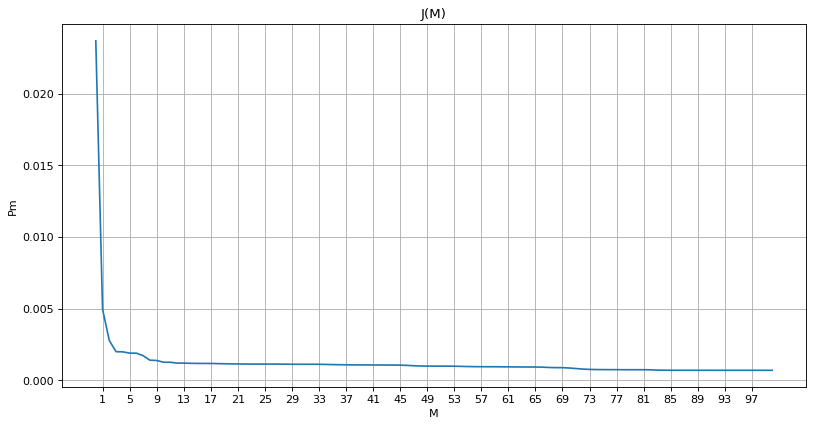

In [11]:
# Representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.
i = 101
r = autocorreltion(resampled_a)
r = r[r.argmax():r.argmax()+i]
M = len(r)-1
m = np.arange(0,M+1)
_, p_list = LevinsonDurbin(r)
plot_m_vs_j(m, p_list)

### Forward prediction of 'sh' signal with $ N_{o} = 1 $:

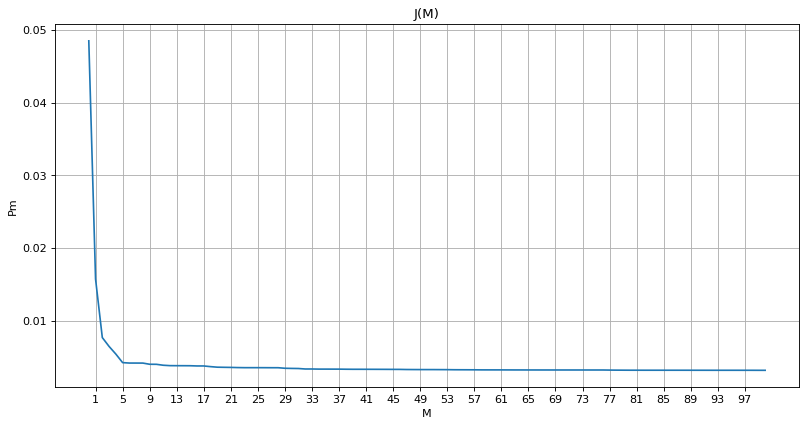

In [12]:
# Representar el error cuadrático medio J en función de M, para valores de M entre 1 y 100.
i = 101
r = autocorreltion(resampled_sh)
r = r[r.argmax():r.argmax()+i]
M = len(r)-1
m = np.arange(0,M+1)
_, p_list = LevinsonDurbin(r)
plot_m_vs_j(m, p_list)

### 3. Para ambos sonidos, analizar cualitativa y cuantitativamente la señal del error de predicción y el espectro $ H(e^{jω}) $ del filtro autorregresivo estimado para M = 1, 6, 12, 24, 100. Comparar este espectro con el espectro obtenido por estimación no-paramétrica.

In [13]:
import math

def AR_Filter(ar_coefs,f_vect):
  spectrum = np.zeros(len(f_vect))
  k = np.array(range(1, len(ar_coefs)+1), dtype = complex)
  for i in range(0, len(f_vect)):
    aux_sum = 0
    delays = np.exp( complex(real=0,imag=-(2*math.pi*f_vect[i])) *k )
    den = 1- np.dot(np.conj(ar_coefs),delays)
    spectrum[i] = 1. / abs( den + 1e-15 )
  return spectrum


In [14]:
def filterW(data, w_o):
    samples = len(data)
    filtered = np.zeros(samples)
    filtered = sig.lfilter(w_o, [1], data)
    return filtered

In [15]:
def plot_fm_fft(fs, data, m=None):
    N = len(data)
    fft_res = fft(x=data, n=N)
    freqs = np.linspace(0, fs/2, N//2)
    if m== None:
      plt.semilogx(freqs, np.abs(fft_res[:N//2]), label='original')
    else:
      plt.semilogx(freqs, np.abs(fft_res[:N//2]), label='M = '+str(m))

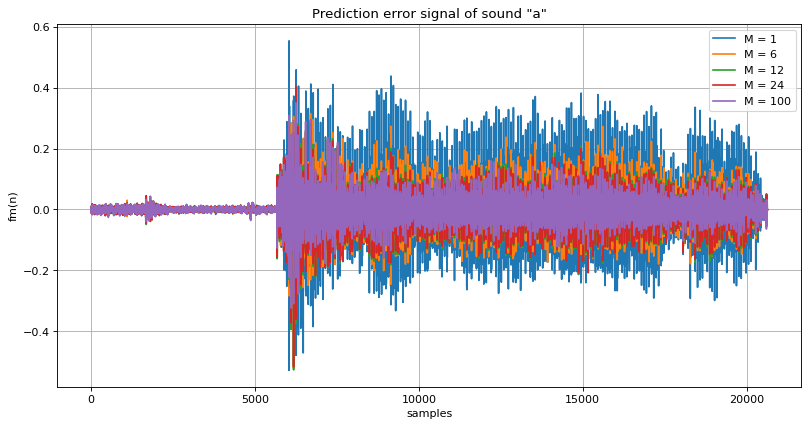

In [16]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('fm(n)')
plt.xlabel('samples')
plt.title('Prediction error signal of sound "a"')
plt.grid('on')

for M in (1, 6, 12, 24, 100):
    i = M+1
    r = autocorreltion(norm_a)
    r = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r)
    fm = filterW(norm_a, a_coefs)
    plt.plot(fm, label='M = '+str(M))
    #plt.plot(a_coefs, label='M = '+str(M))
plt.legend()
plt.show()

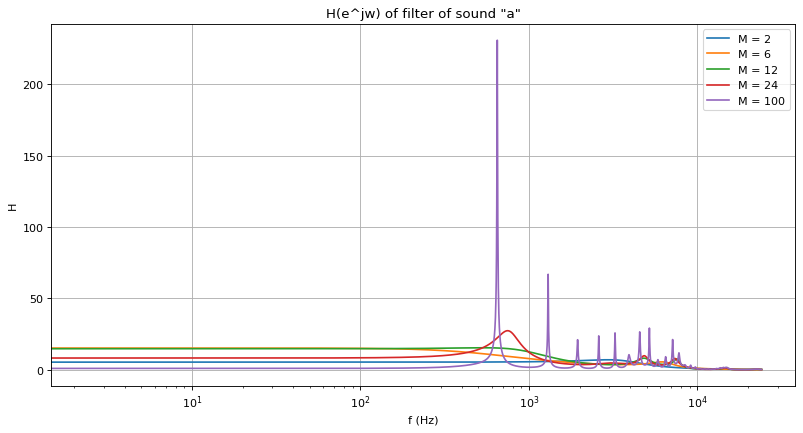

In [17]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('H')
plt.xlabel('f (Hz)')
plt.title('H(e^jw) of filter of sound "a"')
plt.grid('on')

N = len(norm_a)
freqs = np.linspace(0, 0.5, N//2)
r = autocorreltion(norm_a)
for M in (2, 6, 12, 24,100):
    i = M+1
    r_trunc = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r_trunc)
    psd = AR_Filter(-a_coefs[1:],freqs)
    plt.semilogx(freqs*fs, psd, label='M = '+str(M))
plt.legend()
plt.show()

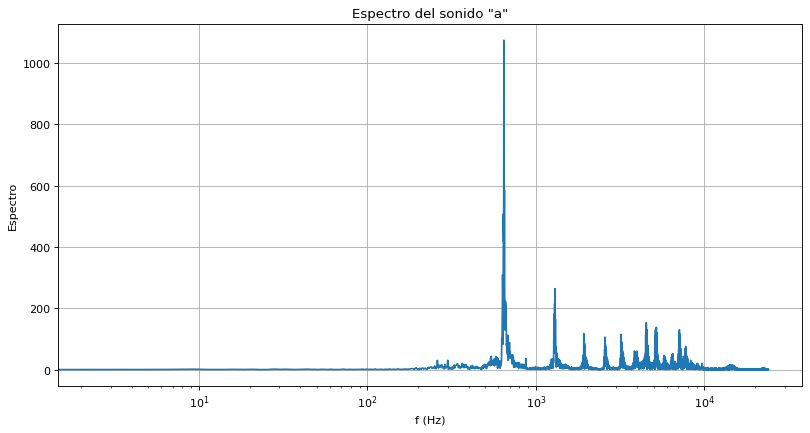

In [18]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Espectro')
plt.xlabel('f (Hz)')
plt.title('Espectro del sonido "a"')
plt.grid('on')
plot_fm_fft(fs, norm_a)
plt.show()

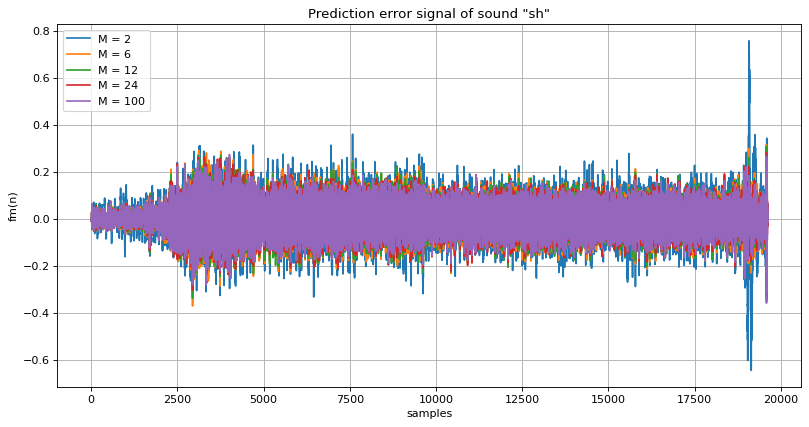

In [19]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('fm(n)')
plt.xlabel('samples')
plt.title('Prediction error signal of sound "sh"')
plt.grid('on')

r = autocorreltion(norm_sh)
for M in (2, 6, 12, 24, 100):
    i = M+1
    r_trunc = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r_trunc)
    fm = filterW(norm_sh, a_coefs)
    plt.plot(fm, label='M = '+str(M))
plt.legend()
plt.show()

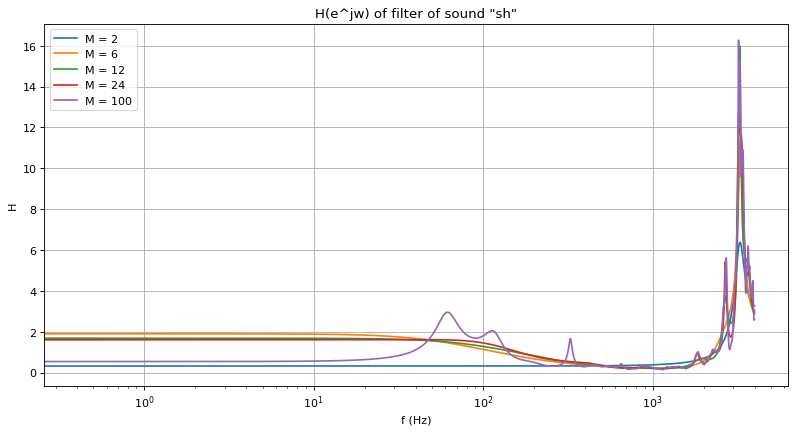

In [20]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('H')
plt.xlabel('f (Hz)')
plt.title('H(e^jw) of filter of sound "sh"')
plt.grid('on')

fs = 8000
r = autocorreltion(norm_sh)
N = len(norm_sh)
freqs = np.linspace(0, 0.5, N//2)
for M in (2, 6, 12, 24, 100):
    i = M+1
    r_trunc = r[r.argmax():r.argmax()+i]
    a_coefs, p_list = LevinsonDurbin(r_trunc)
    psd = AR_Filter(-a_coefs[1:],freqs)
    plt.semilogx(freqs*fs, psd, label='M = '+str(M))
plt.legend()
plt.show()

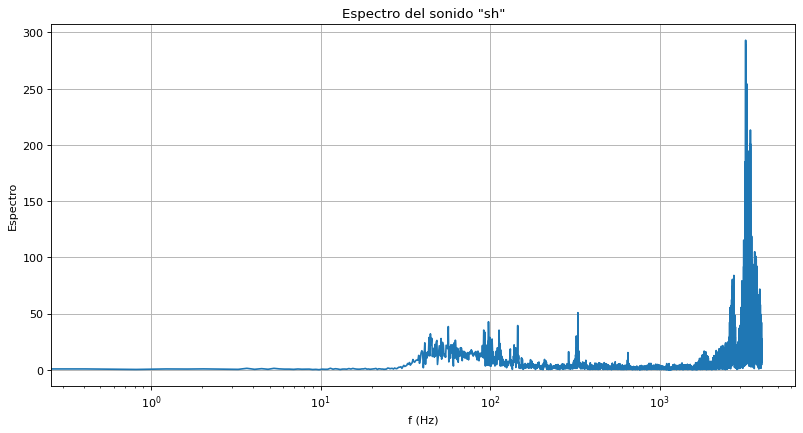

In [21]:
plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Espectro')
plt.xlabel('f (Hz)')
plt.title('Espectro del sonido "sh"')
plt.grid('on')
plot_fm_fft(fs, norm_sh)
plt.show()

### 4. ¿Cuál es el orden óptimo Mo para cada sonido?

De la grafica de Jm se puede ver que ya a partir de M=12 el error cuadratico medio se queda practicamente estancado para ambos sonidos.

Sin embargo, para la sintesis de los sonidos se tiene que la misma cambia notablemente al seguir aumento el M mas alla de 12.

Para el sonido de "aaah", consideramos que con M=70 ya se tiene una sintesis bastante similar a la original. Mientras que para el sonido de "shhh", consideramos que con M=12 el sonido sintetizado ya se escucha muy similar al original.

In [22]:
Mopt_ah = 70
Mopt_sh = 12

### 5. Sintetizar los sonidos aplicando el filtro autorregresivo estimado de orden Mo a una excitación apropiada.

In [23]:
def get_ak_wk_pm(data, M):
    i = M+1
    r = autocorreltion(data)
    r = r[r.argmax():r.argmax()+i]
    ak, p_list = LevinsonDurbin(r)
    wk = a_sub_k_to_w_sub_k(ak)
    return ak, wk, p_list[-1]

In [24]:
def synth(v_n, wk):
    y_synth = np.zeros(len(v_n) + len(wk)) #Concateno M ceros de mas al principio
    for k in range(len(wk), len(y_synth)):
        y_aux = 0
        for i in range(0,len(wk)):
          y_aux = y_aux + y_synth[k-1-i]*wk[i]      
        y_synth[k] = y_aux + v_n[k-len(wk)]
    return y_synth[len(wk):]

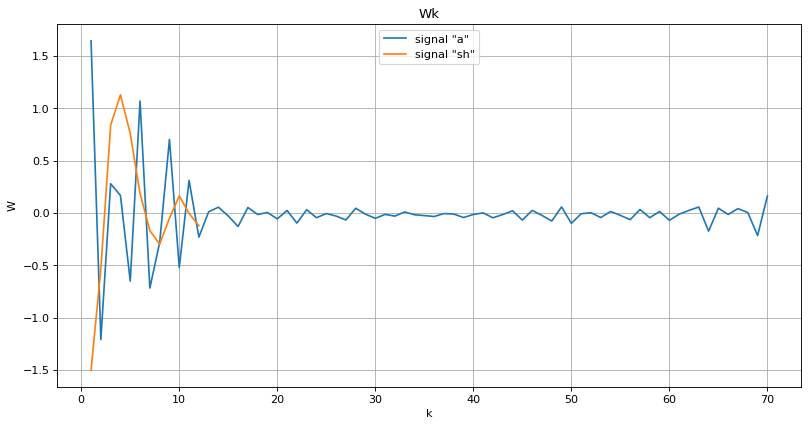

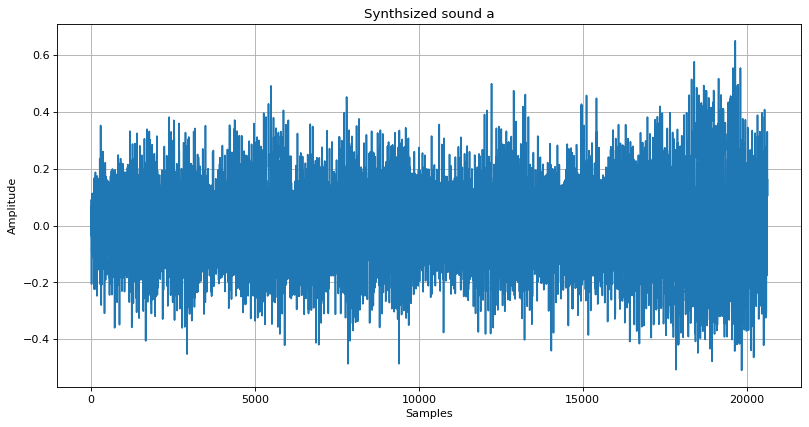

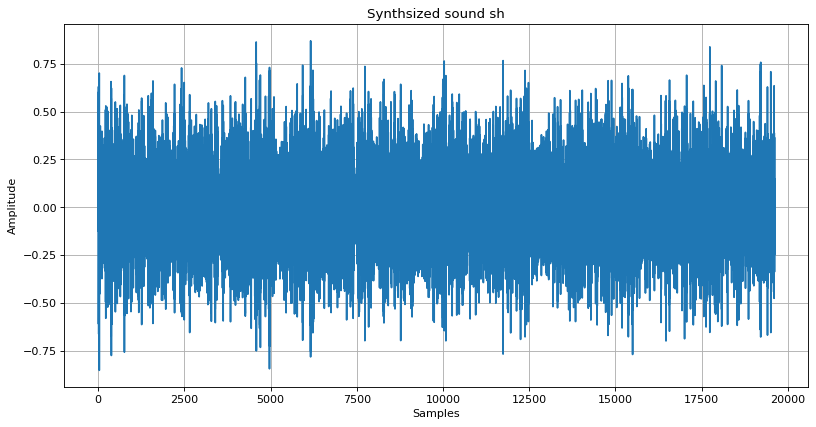

In [25]:
N_a = len(norm_a)
ak_a, wk_a, p_a = get_ak_wk_pm(norm_a, Mopt_ah)
noise_a = np.random.normal(0, np.sqrt(p_a), N_a)

N_sh = len(norm_sh)
ak_sh, wk_sh, p_sh = get_ak_wk_pm(norm_sh, Mopt_sh)
noise_sh = np.random.normal(0,np.sqrt(p_sh), N_sh)

synth_a = synth(noise_a, wk_a)
synth_sh = synth(noise_sh, wk_sh)

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('W')
plt.xlabel('k')
plt.title('Wk')
plt.grid('on')
plt.plot(np.arange(1,Mopt_ah+1), wk_a, label='signal "a"')
plt.plot(np.arange(1,Mopt_sh+1), wk_sh, label='signal "sh"')
plt.legend(loc='upper center')
plt.show()

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Synthsized sound a')
plt.grid('on')
plt.plot(synth_a)
plt.show()

plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Synthsized sound sh')
plt.grid('on')
plt.plot(synth_sh)
plt.show()

In [26]:
IPython.display.Audio(noise_a,rate=desired_fs)

In [27]:
IPython.display.Audio(noise_sh,rate=desired_fs)

In [28]:
IPython.display.Audio(synth_sh,rate=desired_fs)

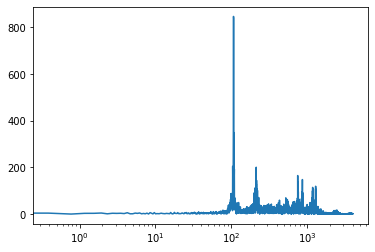

In [29]:
plot_fm_fft(fs, synth_a, 50)

In [30]:
IPython.display.Audio(synth_a,rate=desired_fs)

### 6. Para el sonido /a/ y con Mo, realizar la recursión de Levinson-Durbin y representar los coeficientes κm en función de m.

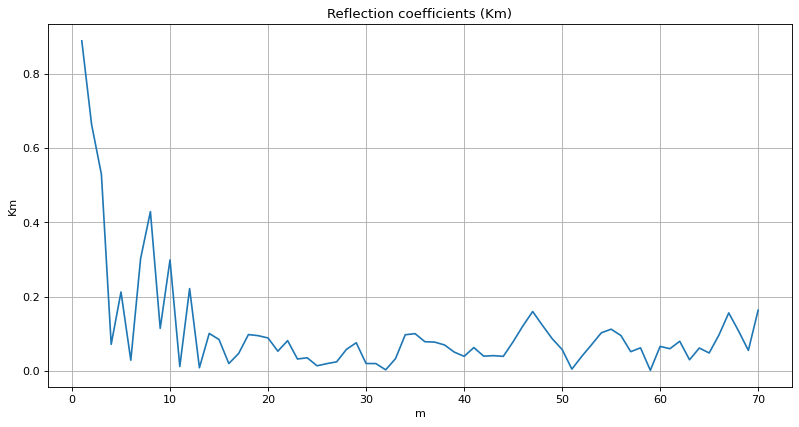

In [31]:
i = Mopt_ah+1
r = autocorreltion(norm_a)
r = r[r.argmax():r.argmax()+i]
_, p_list = LevinsonDurbin(r)
ks = list()

for m in range(1, len(p_list)):
    k_aux = np.sqrt(1-(p_list[m]/p_list[m-1]))
    ks.append(k_aux)


plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.ylabel('Km')
plt.xlabel('m')
plt.title('Reflection coefficients (Km)')
plt.grid('on')
plt.plot(np.arange(1,len(p_list)), ks)
plt.show()